In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
train_data = pd.read_csv("/content/DailyDelhiClimateTrain.csv", parse_dates=["date"])
test_data = pd.read_csv("/content/DailyDelhiClimateTest.csv", parse_dates=["date"])

# Combine datasets for exploration
data = pd.concat([train_data, test_data], ignore_index=True)


# Q1: Explore dataset structure

In [ ]:
print("Dataset Structure:")
print(data.info())

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values (e.g., fill with mean)
data.fillna(data.mean(), inplace=True)

# Describe key statistics
print("\nKey Statistics:")
print(data.describe())


Dataset Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1576 entries, 0 to 1575
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1576 non-null   datetime64[ns]
 1   meantemp      1576 non-null   float64       
 2   humidity      1576 non-null   float64       
 3   wind_speed    1576 non-null   float64       
 4   meanpressure  1576 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 61.7 KB
None

Missing Values:
date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

Key Statistics:
                                date     meantemp     humidity   wind_speed  \
count                           1576  1576.000000  1576.000000  1576.000000   
mean   2015-02-27 10:15:50.253807104    25.221918    60.445229     6.899262   
min              2013-01-01 00:00:00     6.000000    13.428571     0.000000   
25%    

# Q2: Time Series Visualization

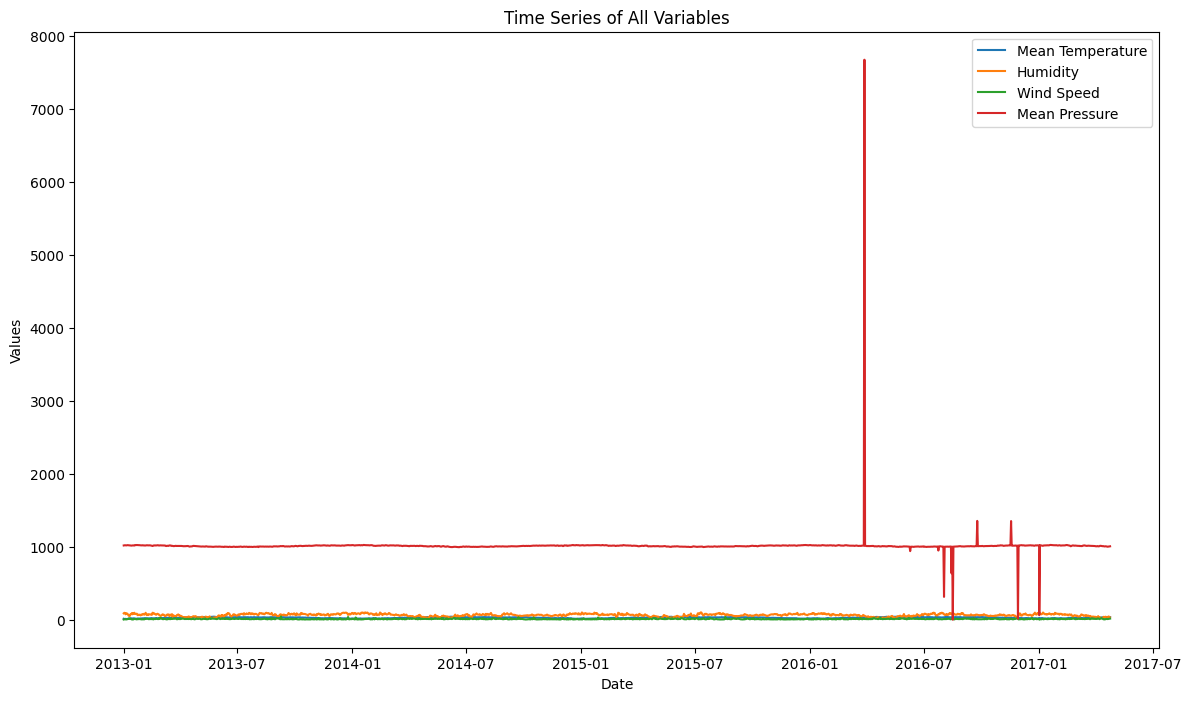

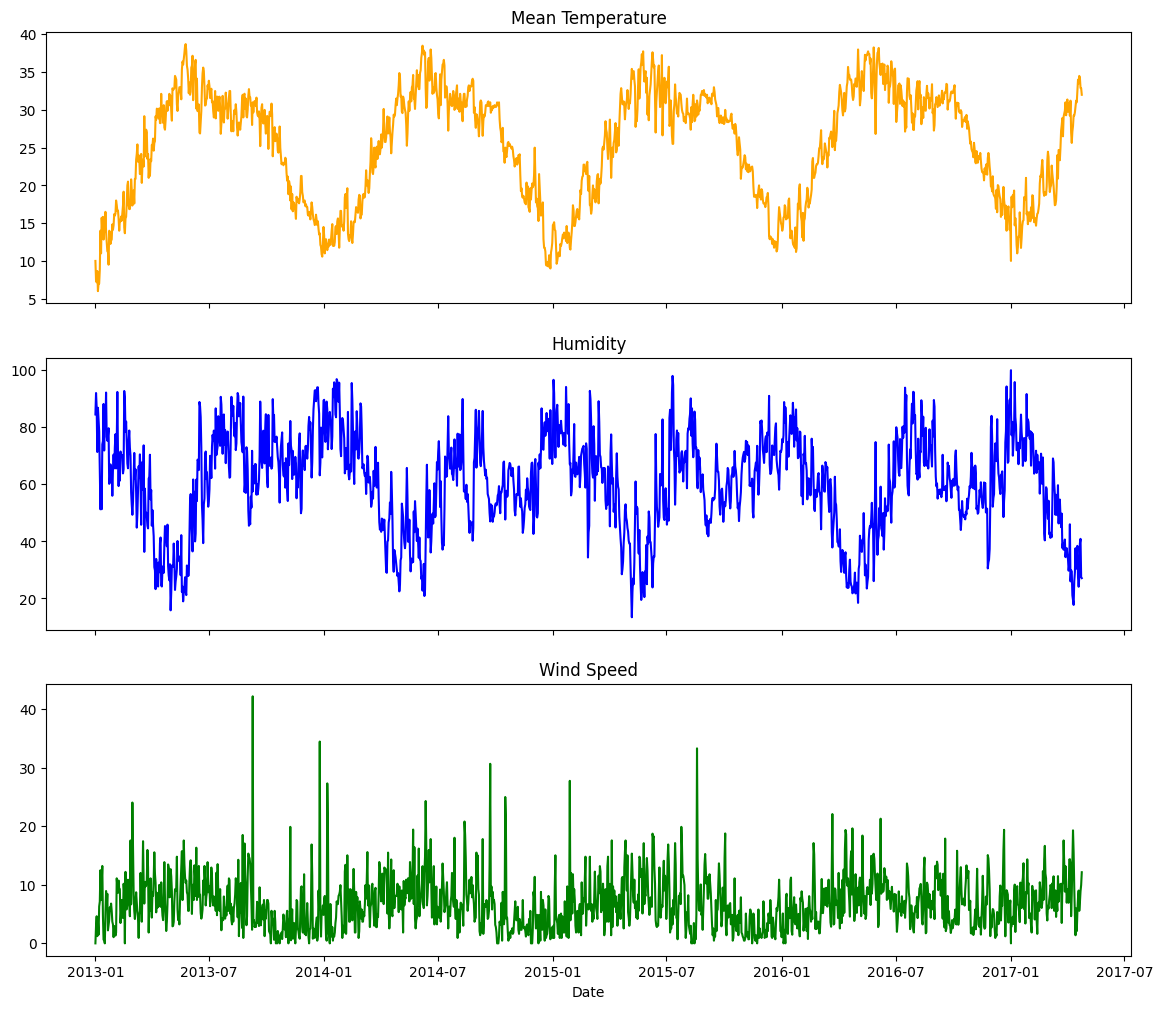

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(data['date'], data['meantemp'], label='Mean Temperature')
plt.plot(data['date'], data['humidity'], label='Humidity')
plt.plot(data['date'], data['wind_speed'], label='Wind Speed')
plt.plot(data['date'], data['meanpressure'], label='Mean Pressure')
plt.legend()
plt.title('Time Series of All Variables')
plt.xlabel('Date')
plt.ylabel('Values')
plt.show()

# Subplots for temperature and wind speed
fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
axes[0].plot(data['date'], data['meantemp'], label='Mean Temperature', color='orange')
axes[0].set_title('Mean Temperature')
axes[1].plot(data['date'], data['humidity'], label='Humidity', color='blue')
axes[1].set_title('Humidity')
axes[2].plot(data['date'], data['wind_speed'], label='Wind Speed', color='green')
axes[2].set_title('Wind Speed')
plt.xlabel('Date')
plt.show()


# Q3: Seasonality and Trends

<Figure size 1400x800 with 0 Axes>

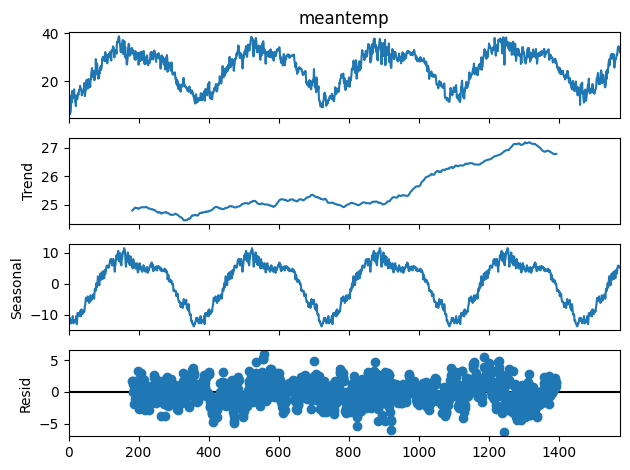


Seasonal Patterns Observed:
0   -11.055743
1   -12.040942
2   -11.330040
3   -11.078111
4   -11.260721
Name: seasonal, dtype: float64


In [ ]:
# Decompose the time series for daily mean temperature
decomposition = seasonal_decompose(data['meantemp'], model='additive', period=365)

plt.figure(figsize=(14, 8))
decomposition.plot()
plt.show()

# Discuss seasonal patterns
print("\nSeasonal Patterns Observed:")
print(decomposition.seasonal.head())


# Q4: Forecasting

Mean Absolute Error (MAE): 13.011466747880759
Root Mean Squared Error (RMSE): 14.88699879868501


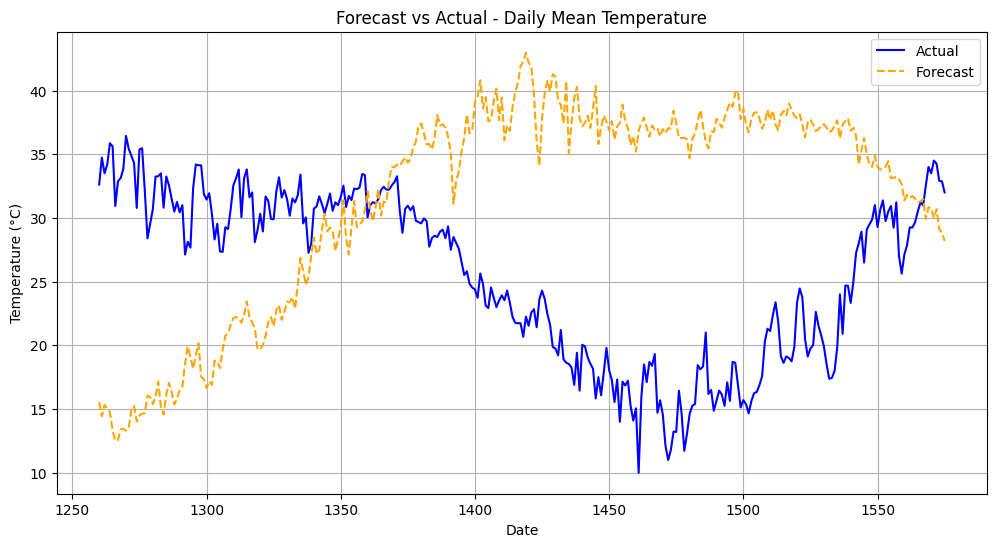

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Split data into training (80%) and testing (20%)
train = data.iloc[:int(len(data) * 0.8)]
test = data.iloc[int(len(data) * 0.8):]

# STL decomposition for training data
decompose_train = seasonal_decompose(train['meantemp'], model='additive', period=365)
trend = decompose_train.trend.dropna()
seasonal = decompose_train.seasonal.dropna()

# Forecast trend by extending the last trend value linearly
trend_diff = trend.iloc[-1] - trend.iloc[-2]
forecast_trend = [trend.iloc[-1] + i * trend_diff for i in range(len(test))]
forecast_trend = np.array(forecast_trend)

# Repeat seasonal pattern to match the length of the forecast
forecast_seasonal = np.tile(seasonal[:len(test)].values, int(np.ceil(len(test) / len(seasonal[:len(test)]))))[:len(test)]

# Combine trend and seasonal components
forecast = forecast_trend + forecast_seasonal

# Evaluate forecast performance
mae = mean_absolute_error(test['meantemp'], forecast)
rmse = np.sqrt(mean_squared_error(test['meantemp'], forecast))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plot actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['meantemp'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', linestyle='dashed', color='orange')
plt.title('Forecast vs Actual - Daily Mean Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid()
plt.show()


# Using LSTM Model

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[['meantemp']])

# Split into training and testing sets
train_size = int(len(data_scaled) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Prepare data for LSTM (input sequences and target values)
def create_sequences(data, sequence_length=30):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

# Build the LSTM model
model = Sequential([
    LSTM(50, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    LSTM(50, activation='relu'),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Forecast
y_pred = model.predict(X_test)

# Inverse scale the predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# Calculate errors
lstm_mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
lstm_rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))

print(f"LSTM Model :\n Mean Absolute Error (MAE): : {lstm_mae:.2f}\n Root Mean Squared Error (RMSE): {lstm_rmse:.2f}")

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.2214
Epoch 2/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0080
Epoch 3/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0066
Epoch 4/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0062
Epoch 5/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0059
Epoch 6/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0057
Epoch 7/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0050
Epoch 8/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0050
Epoch 9/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0049
Epoch 10/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0047
Epoch 11/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0044
Epoch 12/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0041
Epoch 13/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0048
Epoch 14/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0040
Epoch 15/20
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0047
Epoch 16/20
39/

# Using ARIMA Model

ADF Statistic: -2.3791899484520918
p-value: 0.14769623489792388


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA Model : 
 Mean Absolute Error (MAE): 10.18
 Root Mean Squared Error (RMSE): 12.12


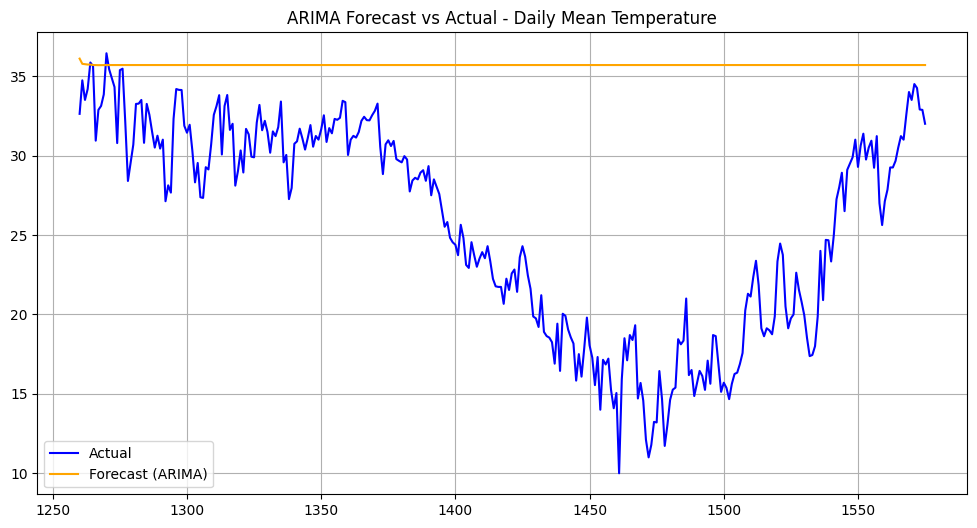

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

# Perform ADF test for stationarity
result = adfuller(data['meantemp'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

# Train ARIMA model
order = (5, 1, 2)  # Use appropriate values based on ACF/PACF analysis
arima_model = ARIMA(train['meantemp'], order=order)
arima_fit = arima_model.fit()

# Forecast
forecast = arima_fit.forecast(steps=len(test))
arima_mae = mean_absolute_error(test['meantemp'], forecast)
arima_rmse = np.sqrt(mean_squared_error(test['meantemp'], forecast))

print(f"ARIMA Model : \n Mean Absolute Error (MAE): {arima_mae:.2f}\n Root Mean Squared Error (RMSE): {arima_rmse:.2f}")

# Plot ARIMA forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['meantemp'], label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast (ARIMA)', color='orange')
plt.title('ARIMA Forecast vs Actual - Daily Mean Temperature')
plt.legend()
plt.grid()
plt.show()